In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import LeaveOneOut
import numpy as np
import copy
import sklearn
from scipy import stats, integrate

from evaluation_metrics import get_file_and_dirnames, get_token_flags, pitch_class_transition_matrix, note_length_transition_matrix
from evaluation_metrics import get_metrics_for_multiple_sequences, summarize_evaluation_sequences

PATH_VOCAB = "../0_data/5_vocabs"
PATH_DATA = "../0_data/6_word_data"
PATH_MODELS = "../0_data/7_models"
PATH_MODELS_CONFIG = "../0_data/7_models/config"
PATH_PRED = "../0_data/8_predictions"
PATH_TOKENS = "../0_data/8_predictions/tokens"
PATH_MIDI = "../0_data/8_predictions/midi"

In [3]:
vocab_configs = {
    "a1" : {
        "pitch_range": 128,
        "duration_steps": 64,
        "triole_tokens": False,
        "key": "all",
    },
    "a2" : {
        "pitch_range": 128,
        "duration_steps": 64,
        "triole_tokens": True,
        "key": "all",
    },
    "a3" : {
        "pitch_range": 128,
        "duration_steps": 32,
        "triole_tokens": False,
        "key": "all",
    },
    "b" : {
        "pitch_range": 128,
        "duration_steps": 64,
        "triole_tokens": False,
        "key": "C",
    },
    "c" : {
        "pitch_range": 36,
        "duration_steps": 64,
        "triole_tokens": False,
        "key": "all",
    },
    "d" : {
        "pitch_range": 36,
        "duration_steps": 32,
        "triole_tokens": True,
        "key": "C",
    }
}

In [7]:
seq_metrics_dic = {}

for key in vocab_configs.keys():
    
    path = f"{PATH_DATA}/{key}_token_data.json"
    with open(path, "r") as fp:
        tokens = json.load(fp)
    token_data = [tokens[key] for key in tokens.keys()]

    token_flags = get_token_flags(vocab_configs[key])
    seq_metrics = get_metrics_for_multiple_sequences(token_data, token_flags)
    seq_metrics_dic[key] = seq_metrics

model_df = pd.read_excel(f"{PATH_MODELS}/model_stats.xlsx", index_col="Unnamed: 0")

for index, row in model_df.iterrows():

    if row["ran"] == "no" or row["runtime"] == "too big - cuda error":
        continue

    model_name = row["name"]
    with open(f"{PATH_TOKENS}/{model_name}.json", "r") as fp:
        tokens = json.load(fp)
    token_data = tokens["data"]

    token_flags = get_token_flags(vocab_configs["d"])
    seq_metrics = get_metrics_for_multiple_sequences(token_data, token_flags)
    seq_metrics_dic[model_name] = seq_metrics

In [17]:
scalar_metrics = [
    "mean_pitch",
    "pitch_count_seq", 
    "pitch_count_bar",
    "pitch_range_seq",
    "pitch_range_bar",
    "pitch_intervals_avg",
    "pitch_intervals_avg_abs",
    "crooked_pitch_count",
    "note_count_seq",
    "note_count_bar",
    "onset_intervals_avg",
    "mean_duration",
]

hist_metrics = [
    "pitch_intervals_hist",
    "pitch_class_hist_numbers",
    #"pitch_class_hist_pitches",
    "onset_intervals_hist",
    "note_length_hist_numbers",
    #"note_length_hist_bins"
]

matrix_metrics = [
    "pitch_class_transition_matrix",
    "note_length_transition_matrix"
]

metrics_list = scalar_metrics + hist_metrics + matrix_metrics

set1_eval = {key: seq_metrics_dic["a1"][key] for key in metrics_list}
set2_eval = {key: seq_metrics_dic["d"][key] for key in metrics_list}

In [25]:
def c_dist(A, B):
    c_dist = np.zeros(len(B))
    for i in range(0, len(B)):
        c_dist[i] = np.linalg.norm(A - B[i])
    return c_dist

# Calculate overlap between the two PDF
def overlap_area(A, B):
    pdf_A = stats.gaussian_kde(A)
    pdf_B = stats.gaussian_kde(B)
    return integrate.quad(lambda x: min(pdf_A(x), pdf_B(x)), np.min((np.min(A), np.min(B))), np.max((np.max(A), np.max(B))))[0]


# Calculate KL distance between the two PDF
def kl_dist(A, B, num_sample=1000):
    pdf_A = stats.gaussian_kde(A)
    pdf_B = stats.gaussian_kde(B)
    sample_A = np.linspace(np.min(A), np.max(A), num_sample)
    sample_B = np.linspace(np.min(B), np.max(B), num_sample)
    return stats.entropy(pdf_A(sample_A), pdf_B(sample_B))

def get_metric_distances(set_1, set_2, metrics):

    num_samples = min(len(set_1[metrics[0]]), len(set_2[metrics[0]]))

    loo = LeaveOneOut()
    loo.get_n_splits(np.arange(num_samples))
    set1_intra = np.zeros((num_samples, len(metrics), num_samples - 1))
    set2_intra = np.zeros((num_samples, len(metrics), num_samples - 1))
    sets_inter = np.zeros((num_samples, len(metrics), num_samples))

    # Calculate Inter-set Metrics
    for i, metric in enumerate(metrics):
        for train_index, test_index in loo.split(np.arange(num_samples)):
            set1_test_sample = set_1[metric][test_index[0]]
            set1_train_samples = [set_1[metric][index] for index in train_index]
            set2_test_sample = set_2[metric][test_index[0]]
            set2_train_samples = [set_2[metric][index] for index in train_index]
            set1_intra[test_index[0]][i] = c_dist(
                set1_test_sample, set1_train_samples)
            set2_intra[test_index[0]][i] = c_dist(
                set2_test_sample, set2_train_samples)

    # Calculate Inter-set Metrics
    for i, metric in enumerate(metrics):
        try:
            for train_index, test_index in loo.split(np.arange(num_samples)):
                sets_inter[test_index[0]][i] = c_dist(set_1[metric][test_index[0]], set_2[metric])
        except ValueError:
            print(f"ValueError for {metric}")

    plot_set1_intra = np.transpose(
        set1_intra, (1, 0, 2)).reshape(len(metrics), -1)
    plot_set2_intra = np.transpose(
        set2_intra, (1, 0, 2)).reshape(len(metrics), -1)
    plot_sets_inter = np.transpose(
        sets_inter, (1, 0, 2)).reshape(len(metrics), -1)
    
    output = {}
    for i, metric in enumerate(metrics):
        
        mean1 = np.mean(set_1[metric], axis=0).tolist()
        std1 = np.std(set_1[metric], axis=0).tolist()
        mean2 = np.mean(set_2[metric], axis=0).tolist()
        std2 = np.std(set_2[metric], axis=0).tolist()
        try:
            kl1 = kl_dist(plot_set1_intra[i], plot_sets_inter[i])
            ol1 = overlap_area(plot_set1_intra[i], plot_sets_inter[i])
            kl2 = kl_dist(plot_set2_intra[i], plot_sets_inter[i])
            ol2 = overlap_area(plot_set2_intra[i], plot_sets_inter[i])
        except:
            kl1, ol1, kl2, ol2 = "error", "error", "error", "error"

        output[metric] = {
            "mean_set1": mean1,
            "std_set1": std1,
            "mean_set2": mean2,
            "std_set2": std2,
            "kl_set1_inter": kl1,
            "ol_set1_inter": ol1,
            "kl_set2_inter": kl2,
            "ol_set2_inter": ol2
        }
        
    return output

In [10]:
output = get_metric_distances(set1_eval, set2_eval, metrics_list)

ValueError for note_length_transition_matrix


/var/folders/9w/zlqt6v1d55l_8s4sn0v5hd2h0000gq/T/ipykernel_27711/1737649661.py:11: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(lambda x: min(pdf_A(x), pdf_B(x)), np.min((np.min(A), np.min(B))), np.max((np.max(A), np.max(B))))[0]


In [12]:
pd.DataFrame(output)

,pitch_count_seq,pitch_count_bar,pitch_range_seq,pitch_range_bar,pitch_intervals_avg,pitch_intervals_avg_abs,crooked_pitch_count,note_count_seq,note_count_bar,onset_intervals_avg,pitch_intervals_hist,pitch_class_hist_numbers,onset_intervals_hist,note_length_hist_numbers,pitch_class_transition_matrix,note_length_transition_matrix
mean,11.446785,3.438016,18.490022,6.054867,0.009257,2.395388,127.890244,340.176275,5.705942,2.997217,"[80.48669623059867, 27.595343680709533, 121.60...","[29.92239467849224, 25.120842572062084, 31.871...","[9.335920177383592, 79.12749445676275, 146.446...","[7.342572062084257, 121.57427937915743, 50.505...","[[6.957871396895787, 0.9190687361419069, 5.366...","[[0.20842572062084258, 2.8802660753880267, 1.3..."
std,2.997957,0.593455,3.621415,1.393016,0.021169,0.437286,107.727247,90.528094,1.767262,0.872022,"[56.233963866948955, 26.557415950258658, 38.99...","[32.430183711344476, 31.732351942807977, 33.02...","[36.472740119507165, 81.51768772830378, 86.063...","[14.57685288214473, 96.87097118884739, 57.5000...","[[11.660211454664895, 3.7725070354214383, 9.45...","[[4.825424164176308, 7.277601997793952, 4.0317..."
kl1,0.007666,0.000205,0.020513,0.000379,2.145874,0.012666,0.043042,0.000659,inf,0.001599,inf,0.037992,0.001614,0.028634,0.005467,error
ol1,0.899837,0.983873,0.866611,0.983946,0.917680,0.981851,0.845608,0.977944,0.977432,0.978925,0.993199,0.961298,0.982003,0.878579,0.973452,error
kl2,0.944316,0.000037,0.891025,0.000023,0.000642,0.028825,0.649899,0.278580,inf,0.016092,inf,0.141853,0.690199,0.139871,0.617598,error
ol2,0.879984,0.984520,0.822266,0.984444,0.916461,0.982203,0.296179,0.979273,0.978973,0.978940,0.992429,0.421741,0.993733,0.879222,0.5342,error


In [14]:
seq_metrics_dic["5_middle_medium_50"].keys()

dict_keys(['mean_pitch', 'pitch_count_seq', 'pitch_count_bar', 'pitch_range_seq', 'pitch_range_bar', 'pitch_intervals_avg', 'pitch_intervals_avg_abs', 'pitch_intervals_hist', 'pitch_class_hist_numbers', 'pitch_class_hist_pitches', 'crooked_pitch_count', 'pitch_class_transition_matrix', 'note_count_seq', 'note_count_bar', 'onset_intervals_avg', 'onset_intervals_hist', 'mean_duration', 'note_length_hist_numbers', 'note_length_hist_bins', 'note_length_transition_matrix'])

In [28]:
set1_eval = {key: seq_metrics_dic["5_middle_medium_50"][key] for key in metrics_list}
set2_eval = {key: seq_metrics_dic["6_middle_large_50"][key] for key in metrics_list}
output2 = get_metric_distances(set1_eval, set2_eval, metrics_list)

In [29]:
output2

{'mean_pitch': {'mean_set1': 15.739999999999998,
  'std_set1': 2.5665774876282224,
  'mean_set2': 15.782,
  'std_set2': 2.3425234257099756,
  'kl_set1_inter': 0.03846338383673224,
  'ol_set1_inter': 0.7636063945844545,
  'kl_set2_inter': 0.03887479073324294,
  'ol_set2_inter': 0.7800150123731967},
 'pitch_count_seq': {'mean_set1': 10.8,
  'std_set1': 0.9797958971132713,
  'mean_set2': 14.8,
  'std_set2': 1.7204650534085253,
  'kl_set1_inter': 0.3124463084991116,
  'ol_set1_inter': 0.3430072950062159,
  'kl_set2_inter': 0.0451886106487223,
  'ol_set2_inter': 0.6538927769645692},
 'pitch_count_bar': {'mean_set1': 3.502,
  'std_set1': 0.7696856501195798,
  'mean_set2': 3.518,
  'std_set2': 0.3783860462543514,
  'kl_set1_inter': 0.26614864922506837,
  'ol_set1_inter': 0.6194067500263405,
  'kl_set2_inter': 0.22383651868046256,
  'ol_set2_inter': 0.6981418067401174},
 'pitch_range_seq': {'mean_set1': 19.4,
  'std_set1': 1.4966629547095764,
  'mean_set2': 20.4,
  'std_set2': 1.95959179422654

In [30]:
output["pitch_count_seq"]

{'mean': 11.446784922394679,
 'std': 2.997956746217249,
 'kl1': 0.007666235286007449,
 'ol1': 0.8998369757040714,
 'kl2': 0.9443156090452987,
 'ol2': 0.8799838533050323}

In [32]:
mu = 11.446784922394679
sigma = 2.997956746217249

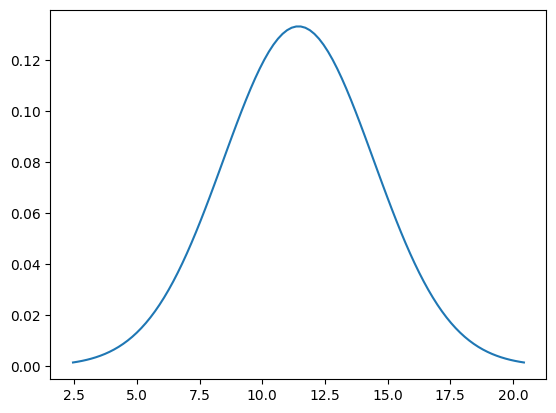

In [33]:
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

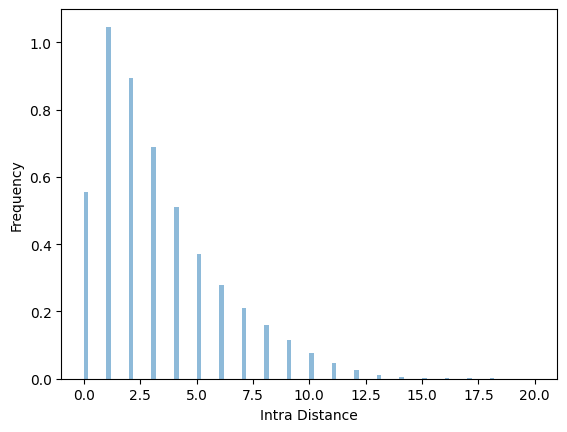

In [97]:
# plot the histogram using hist()
plt.hist(plot_set1_intra[0], bins=100, density=True, alpha=0.5)

# set the x and y labels
plt.xlabel('Intra Distance')
plt.ylabel('Frequency')

# show the plot
plt.show()